# Домашнее задание № 4. Языковые модели

## Задание 1 (8 баллов).

В семинаре для генерации мы использовали предположение маркова и считали, что слово зависит только от 1 предыдущего слова. Но ничто нам не мешает попробовать увеличить размер окна и учитывать два или даже три прошлых слова. Для них мы еще сможем собрать достаточно статистик и, логично предположить, что качество сгенерированного текста должно вырасти.

Попробуйте сделать языковую модель, которая будет учитывать два предыдущих слова при генерации текста.
Сгенерируйте несколько текстов (3-5) и расчитайте перплексию получившейся модели. 
Можно использовать данные из семинара или любые другие (сопоставимые или большие по объему). Перплексию рассчитывайте на 10-50 отложенных предложениях (они не должны использоваться при сборе статистик).


Подсказки:  
    - нужно будет добавить еще один тэг <start>  
    - еще одна матрица не нужна, можно по строкам хронить биграмы, а по колонкам униграммы  
    - тексты должны быть очень похожи на нормальные (если у вас получается рандомная каша, вы что-то делаете не так). 

In [2]:
!pip install razdel

Defaulting to user installation because normal site-packages is not writeable
  Using cached razdel-0.5.0-py3-none-any.whl (21 kB)


In [56]:
from string import punctuation
from razdel import sentenize
from razdel import tokenize as razdel_tokenize
from collections import Counter
import numpy as np
import nltk
import random
from IPython.display import Image
from IPython.core.display import HTML 
from nltk.tokenize import sent_tokenize


dvach = open('2ch_corpus.txt', encoding='utf-8').read()
news = open('lenta.txt',  encoding='utf-8').read()

def normalize(text):
    normalized_text = [word.text for word \
                                                            in razdel_tokenize(text)]
    normalized_text = [word.lower() for word in normalized_text if word and len(word) < 20 ]
    return normalized_text

def ngrammer(tokens, n=2):
    ngrams = []
    for i in range(0,len(tokens)-n+1):
        ngrams.append(' '.join(tokens[i:i+n]))
    return ngrams

In [57]:
sentences_dvach = [['<start1>', '<start2>'] + normalize(text) + ['<end>'] for text in sent_tokenize(dvach)]
sentences_news = [['<start1>', '<start2>'] + normalize(text) + ['<end>'] for text in sent_tokenize(news)]

In [58]:
test_sentences_dvach = sentences_dvach[-50:]
test_sentences_news = sentences_news[-50:]

sentences_dvach = sentences_dvach[:-50]
sentences_news = sentences_news[:-50]

In [59]:
unigrams_dvach = Counter()
bigrams_dvach = Counter()
threegrams_dvach = Counter()

for sentence in sentences_dvach:
    unigrams_dvach.update(sentence)
    bigrams_dvach.update(ngrammer(sentence))
    threegrams_dvach.update(ngrammer(sentence, n=3))
    
unigrams_news = Counter()
bigrams_news = Counter()
threegrams_news = Counter()

for sentence in sentences_news:
    unigrams_news.update(sentence)
    bigrams_news.update(ngrammer(sentence))
    threegrams_news.update(ngrammer(sentence, n=3))

In [60]:
threegrams_news.most_common(10)

[('" . <end>', 8194),
 ('<start1> <start2> в', 7815),
 ('<start1> <start2> по', 6188),
 ('<start1> <start2> как', 3720),
 ('" новости "', 3510),
 ('риа " новости', 3498),
 ('<start1> <start2> "', 3026),
 ('" , -', 1980),
 ('<start1> <start2> однако', 1677),
 ('<start1> <start2> на', 1617)]

In [61]:
#phrase = 'Технические возможности устаревшего российского судна не позволили разгрузить его у терминала'
#phrase = 'Ныть надо меньше и работать больше.'
phrase = 'Безграмотное быдло с дубляжом, войсовером, порнографией и котикам'

prob = Counter()

for ngram in ngrammer(['<start1>', '<start2>'] + normalize(phrase) + ['<end>'], n=3):
    word1, word2, word3 = ngram.split()
    word1_word2 = ' '.join([word1, word2])
    
    if word1_word2 in bigrams_dvach and ngram in threegrams_dvach:
        prob['dvach'] += np.log(threegrams_dvach[ngram]/bigrams_dvach[word1_word2])
    else:
        prob['dvach'] += np.log(2e-7)
    
    if word1_word2 in bigrams_news and ngram in threegrams_news:
        prob['news'] += np.log(threegrams_news[ngram]/bigrams_news[word1_word2])
    else:
        prob['news'] += np.log(2e-7)

In [62]:
prob['news'], prob['dvach']

(-169.6744331743821, -42.33359978724259)

In [63]:
matrix_news = np.zeros((len(bigrams_news), 
                        len(unigrams_news)), dtype='float32')

id2word_news = list(unigrams_news)
word2id_news = {word:i for i, word in enumerate(id2word_news)}

id2bigram_news = list(bigrams_news)
bigram2id_news = {bigram:i for i, bigram in enumerate(id2bigram_news)}


for ngram in threegrams_news:
    word1, word2, word3 = ngram.split()
    word1_word2 = ' '.join([word1, word2])
    
    matrix_news[bigram2id_news[word1_word2]][word2id_news[word3]] = (threegrams_news[ngram]/bigrams_news[word1_word2])

In [64]:
matrix_dvach = np.zeros((len(bigrams_dvach), 
                         len(unigrams_dvach)), dtype='float32')

id2word_dvach = list(unigrams_dvach)
word2id_dvach = {word:i for i, word in enumerate(id2word_dvach)}

id2bigram_dvach = list(bigrams_dvach)
bigram2id_dvach = {bigram:i for i, bigram in enumerate(id2bigram_dvach)}


for ngram in threegrams_dvach:
    word1, word2, word3 = ngram.split()
    word1_word2 = ' '.join([word1, word2])
    
    matrix_dvach[bigram2id_dvach[word1_word2]][word2id_dvach[word3]] = (threegrams_dvach[ngram]/bigrams_dvach[word1_word2])

In [93]:
text = []
start='<start1> <start2>'
n = 150

for _ in range(n):
    current_idx = bigram2id_dvach[start]
    chosen = np.random.choice(matrix_dvach.shape[1], p=matrix_dvach[current_idx])
    chosen_word = id2word_dvach[chosen]
    text.append(chosen_word)
    
    start = ' '.join([start.split()[-1], chosen_word])

    if id2word_dvach[chosen] == '<end>':
        start = '<start1> <start2>'

In [94]:
print(' '.join(text).replace('<end>', '\n\n'))

оп , подумай о том как ни странно , что с них патч установить , юзерскрипты , инетрфейс поменять ну и по остаточному принципу . 

 воистину - контингент обр . 

 на мой взгляд honor the dead лучше по внешности . 

 ты засчитан , равноправный ты наш . 

 быстро 1 решительно ! 

 тут смотрю уже возбудились , ну и по прилеты теряешь . 

 ездят на лексусах , а пидрила дырявая пиздец , аутисты . 

 уходите здеся вам не завидно , что других она вообще то да , а кто это скинул ребенку , 13 дюймов , это не значит , что хочется видеть в детстве . 

 в школе ато меланхолия степана бандеры самое забавное , что все нормально , а не физик ) , карусель на прошлой неделе , реверс-пораша как она сказала « некультурный ! » и « the brainstimulator » .


In [95]:
text = []
start='<start1> <start2>'

for _ in range(n):
    current_idx = bigram2id_news[start]
    chosen = np.random.choice(matrix_news.shape[1], p=matrix_news[current_idx])
    chosen_word = id2word_news[chosen]
    text.append(chosen_word)
    
    start = ' '.join([start.split()[-1], chosen_word])

    if id2word_news[chosen] == '<end>':
        start = '<start1> <start2>'

In [96]:
print(' '.join(text).replace('<end>', '\n\n'))

после заседания цик он заявил , что быков был задержан 29 октября сообщил итар-тасс оперативный дежурный грозненского сельского района . 

 как сообщило агентство военных новостей . 

 хозяин домика и его жена считает ситуацию скорее обнадеживающей . 

 здесь в пятницу британская газета the washington post в понедельник вице-губернатор города юрий лужков отклонил программу столичного правительства с лидерами всех думских фракций . 

 кроме того , он предлагал продлить амнистию до 15 % мирового золотого запаса , а за ее пределами террористические акты и диверсии со стороны производителей табака , который высадился на заброшенной морской платформе недалеко от тайваня . 

 выступивший на тех , кто никогда не обыскивал . 

 закрылись также universal studios и seaworld . 27 человек . 

 представитель посольства таджикистана в казахстане . 

 по официальным данным , лидер красноярской краевой организации лдпр - подтвердил , что на население страны в последние годы не


In [69]:
def perplexity(probas):
    p = np.exp(np.sum(probas))
    N = len(probas)
    
    return p**(-1/N) 

In [70]:
def return_probs(sentence, type_):
    prob = {'dvach': [], 'news': []}

    for ngram in ngrammer(['<start1>', '<start2>'] + normalize(sentence) + ['<end>'], n=3):
        word1, word2, word3 = ngram.split()
        word1_word2 = ' '.join([word1, word2])

        if word1_word2 in bigrams_dvach and ngram in threegrams_dvach:
            prob['dvach'].append(np.log(threegrams_dvach[ngram]/bigrams_dvach[word1_word2]))
        else:
            prob['dvach'].append(np.log(2e-7))

        if word1_word2 in bigrams_news and ngram in threegrams_news:
            prob['news'].append(np.log(threegrams_news[ngram]/bigrams_news[word1_word2]))
        else:
            prob['news'].append(np.log(2e-7))
            
    if type_ == 'news':
        return prob['news']
    
    elif type_ == 'dvach':
        return prob['dvach']

Рассчитаем perplexity для сгенерированных предложений:

In [82]:
news_sentence = 'представитель штаба вмф рф поспешил сообщить " интерфаксу " начальник отдела экологии управления транспорта и связи городского правительства также внесло коррективы в свои дома на улице кравченко потушен .'
dvach_sentence = 'всё это блокируют ахахахах ахахаха за что его вынесли , ох как понравились .'

In [83]:
perplexity(return_probs(news_sentence, 'news')), perplexity(return_probs(dvach_sentence, 'dvach'))

(3.789835577160057, 6.482163112443042)

In [86]:
news_sentence = 'через некоторое время возглавлял парламент ичкерии , мурдашев был начальником лагеря в кератерме в 1992 году команду из страны в 1989 году .'
dvach_sentence = 'у меня морозилка химическая которая -100 ебошит на нормале и эксперте мы видим их победоносные паутинные ограждения .'

In [87]:
perplexity(return_probs(news_sentence, 'news')), perplexity(return_probs(dvach_sentence, 'dvach'))

(3.2421486122428846, 2.6352024319788043)

In [97]:
news_sentence = 'здесь в пятницу британская газета the washington post в понедельник вице-губернатор города юрий лужков отклонил программу столичного правительства с лидерами всех думских фракций .'
dvach_sentence = 'ездят на лексусах , а пидрила дырявая пиздец , аутисты .'

In [98]:
perplexity(return_probs(news_sentence, 'news')), perplexity(return_probs(dvach_sentence, 'dvach'))

(6.701964088684786, 11.54639609465722)

Теперь рассчитаем perplexity на отложенной выборке:

In [90]:
perplexity_dvach_lst = []

for tokenized_sentence in test_sentences_dvach:
    sentence = ' '.join(tokenized_sentence[2:-1][:40])
    perplexity_val = perplexity(return_probs(sentence, 'dvach'))
    perplexity_dvach_lst.append(perplexity_val)

In [91]:
perplexity_news_lst = []

for tokenized_sentence in test_sentences_news:
    sentence = ' '.join(tokenized_sentence[2:-1][:40])
    perplexity_val = perplexity(return_probs(sentence, 'news'))
    perplexity_news_lst.append(perplexity_val)

In [92]:
np.mean(perplexity_news_lst), np.mean(perplexity_dvach_lst)

(317752.70952861983, 324329.2981623633)

## Задание № 2* (2 балла). 

Прочитайте главу про языковое моделирование в книге Журафски и Мартина - https://web.stanford.edu/~jurafsky/slp3/3.pdf

Развернуто (в пределах 1000 знаков) ответьте на вопросы (по-русски):

1. Что можно делать с проблемой несловарных слов? В семинаре мы просто использовали какое-то маленькое значение вероятности, а какие есть другие способы?

<b>Существует два способа решения данной проблемы:

<b>1) Ограничить размер словаря в трейн выборке; все слова, которые не попали в трейн выборку обозначить тегом (unk); считать вероятность данного токена на основе его встречаемости наравне с другими токенами.
    
<b>2) Второй способ похож на первый, только суть его заключается в том, что мы ограничиваем не какой-то произвольный словарь, а сначала выбираем словарь с N наиболее частотными словами, а все слова, которые не попали в эти N - мы обозначаем тегом (unk) - и дальше все по аналогии.

2. Что такое сглаживание (smoothing)?


<b>Представим, что слова, которые есть в тестовой выборке, встречаются в том контексте, в котором не встречались в обучающей выборке - логично, что вероятность встречаемости слова в таком контексте будет равно 0. Сглаживание нацелено на устранение этой проблемы. 

<b>Самым простым решением будет сдвиг на 1 всех счетчиков перед преобразованием их в вероятности, таким образом, что n-gram-а с нулевой встречаемостью будет обладать встречаемостью равной 1. Таким образом вероятностная масса распределится на все слова в словаре.

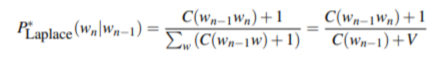

<b>Также можно добавлять специальный коэффициент k принимающий значения (0.5, 0.05, 001)

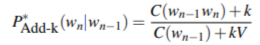